## Run on Colab
You can run this notebook on Colab right away without installing JAX dependencies: https://colab.research.google.com/github/willwhitney/reprieve/blob/master/examples/example.ipynb.

## Run locally
To run this notebook locally please install the [Reprieve dependencies](https://github.com/willwhitney/reprieve#dependencies), in particular JAX with GPU support.

In [1]:
# !pip install flax git+https://github.com/willwhitney/reprieve
!pip uninstall -y reprieve
!pip install -e ../../reprieve

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Found existing installation: reprieve 0.0.1
Uninstalling reprieve-0.0.1:
  Successfully uninstalled reprieve-0.0.1
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Obtaining file:///Users/kati/Documents/dev/reprieve
  Running setup.py develop for reprieve


In [1]:
import os
import pandas as pd

import jax
import torchvision

import reprieve
from reprieve.representations import mnist_vae
from reprieve.mnist_noisy_label import MNISTNoisyLabelDataset
from reprieve.algorithms import mlp as alg

from argparse import Namespace
from functools import reduce
import numpy as np
import torch
from torch.utils.data import Dataset

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
# # make an MNIST dataset
# dataset_mnist = torchvision.datasets.MNIST(
#     './data', train=True, download=True,
#     transform=torchvision.transforms.Compose([
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

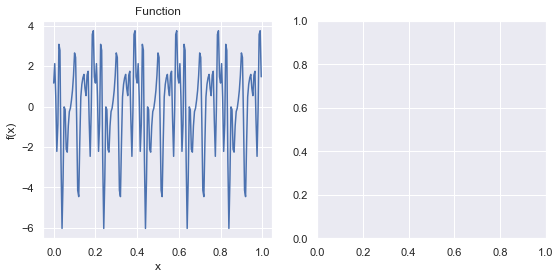

In [2]:
# Data Generation
opt = Namespace()
opt.N = 200
opt.K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
opt.A = [1 for _ in opt.K]
opt.PHI = [np.random.rand() for _ in opt.K]

def make_phased_waves(opt):
    t = np.arange(0, 1, 1./opt.N)
    if opt.A is None:
        yt = reduce(lambda a, b: a + b, 
                    [np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, phi in zip(opt.K, opt.PHI)])
    else:
        yt = reduce(lambda a, b: a + b, 
                    [Ai * np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, Ai, phi in zip(opt.K, opt.A, opt.PHI)])
    return t, yt

def plot_wave_and_spectrum(opt, x, yox):
    # Btw, "yox" --> "y of x"
    # Compute fft
#     k, yok = fft(opt, yox)
    # Plot
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4))
    ax0.set_title("Function")
    ax0.plot(x, yox)
    ax0.set_xlabel("x")
    ax0.set_ylabel("f(x)")
#     ax1.set_title("FT of Function")
#     ax1.plot(k, yok)
#     ax1.set_xlabel("k")
#     ax1.set_ylabel("f(k)")
    plt.show()

x, y = make_phased_waves(opt)
plot_wave_and_spectrum(opt, x, y)

In [3]:
class FaceLandmarksDataset(Dataset):
    """Dataset with different frequencies."""

    def __init__(self, t, yt, transform=None, binary=False):
        """
        Args:
            t: inputs
            yt: targets
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.t = torch.from_numpy(t).view(-1, 1)
        if binary:
            self.yt = torch.from_numpy(yt>0).int()
        else:
            self.yt = torch.from_numpy(yt)
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        sample = (self.t[idx], self.yt[idx])
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
t, yt = make_phased_waves(opt)
dataset_spectral = FaceLandmarksDataset(t, yt)

In [5]:
dataset_spectral.__getitem__(0)

(tensor([0.], dtype=torch.float64), tensor(1.1609, dtype=torch.float64))

In [6]:
# make an MLP algorithm which takes inputs of shape (1,)
# and has 1 output classes (regression)
init_fn, train_step_fn, eval_fn = alg.make_algorithm((1,), 1, n_layers=1, h_dim=10)

# these functions initialize the state of the model given a seed, 
# train on a batch of data, 
# and evaluate on a batch of data

# construct a loss-data estimator and use it to compute the loss-data curve
raw_loss_data_estimator = reprieve.LossDataEstimator(
    init_fn, train_step_fn, eval_fn, dataset_spectral)
raw_results = raw_loss_data_estimator.compute_curve()

/Users/kati/opt/anaconda3/envs/ml/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
# # train a VAE with latent dimension 8
# vae_repr = mnist_vae.build_repr(8)

# # make an MLP algorithm which takes inputs of shape (8,) to match the VAE
# # and has 10 output classes
# init_fn, train_step_fn, eval_fn = alg.make_algorithm((8,), 10)

# # construct a loss-data estimator and use it to compute the loss-data curve
# # pass the VAE as our representation_fn
# vae_loss_data_estimator = reprieve.LossDataEstimator(
#     init_fn, train_step_fn, eval_fn, dataset_mnist, 
#     representation_fn=vae_repr)
# vae_results = vae_loss_data_estimator.compute_curve()

In [8]:
# name our experiments and concatenate them
raw_results['name'] = 'Raw'
# vae_results['name'] = 'VAE'

outcome_df = pd.concat([
    raw_results,
    # vae_results,
])

# pick some settings of n (training set size) and epsilon (loss tolerance)
ns = [60, 20000]
epsilons = [1, 0.2]

In [9]:
# plot the loss-data curves for our representations
reprieve.render_curve(outcome_df, ns, epsilons)

alt.LayerChart(...)

In [10]:
# # compute VA, MDL, SDL, and eSC for both representations
# metrics_df = reprieve.compute_metrics(outcome_df, ns, epsilons)
# metrics_df

In [11]:
# # reprieve even generates LaTeX tables you can paste into a paper
# latex_text = reprieve.render_latex(metrics_df, display=True)